<H3>PRI 2023/24: second
    project delivery</H3>

**GROUP 08**
- Daniele Avolio    , ist1111559
- Michele Vitale	, ist1111558	
- Luís Dias	        , ist198557

<H2>Main facilities</H2>

<h3>Part I: clustering</h3>

*A) Clustering*

This function takes a document, along with optional inverted index and clustering arguments, and returns the best clustering solution for the given task, determined by proper internal indices.

In [1]:
# Imports useful later

import os
import sys
import time
import random
import nltk
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import cluster 
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer



In [2]:
import os  


def read_files(location:str, skip_first_line:bool=True) -> list:
    """
    Read all text files in the specified location and return their contents as a list.
    """
    files_list = []
    
    for root, dirs, files in os.walk(location):
        for file in files:
            if file.endswith(".txt"): 
                with open(os.path.join(root, file), "r") as auto:
                    if skip_first_line: auto.readline()
                    # Skip the first line
                    files_list.append(auto.read().strip())
    return files_list

We will get those from the beginning, so we won't have problems in the future.

In [3]:
documents = read_files("../BBC News Summary/News Articles")
summaries = read_files("../BBC News Summary/Summaries", skip_first_line=False)

In [4]:
print(documents[0])
print()
print(summaries[0])


Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-spe

In [155]:
# hierarchical clustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import math


def sentence_clustering(d: str, I = None, alpha = 1, beta = 0.45, gamma = 0.05, **kwargs):
    # Workflow idea:
    # 1. Split the document into sentences using nltk
    # 2. Convert the sentences into vectors using TfIdf
    # 3. Cluster the vectors using Hierarchical Clustering
    # 4. Return the clusters

    # Problems: How many clusters should we use?
    # Answer: We can use the elbow method to find the optimal number of clusters

    # Problems: How do we know if the clusters are good?
    # Answer: We can use the silhouette score to evaluate the quality of the clusters
   
    sentences = nltk.sent_tokenize(d)

    vectorizer = TfidfVectorizer(stop_words="english")
    X = vectorizer.fit_transform(sentences)

    # Parameter for the score functoin
    # Best number of clusters
    best_score = 0
    best_n_clusters = 0
    

    max_clusters = kwargs.get("max_clusters", len(sentences))

    if max_clusters > len(sentences):
        max_clusters = len(sentences)

    for n_clusters in range(2, max_clusters):
        model = AgglomerativeClustering(
            n_clusters=n_clusters, linkage="complete", metric="cosine"
        )
        labels = model.fit_predict(X.toarray())

        # Calculate the silhouette score, which measures the compactness and separation of the clusters.
        # A higher silhouette score indicates better clustering quality.
        # It ranges from -1 to 1, with 1 being the best score.
        # The goal is to maximize the silhouette score.
        # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

        silhouette_score_value = silhouette_score(X.toarray(), labels) * alpha

        # # Calculate the Calinski-Harabasz score, which measures the ratio of between-cluster dispersion to within-cluster dispersion.
        # # A higher Calinski-Harabasz score indicates better clustering quality.
        # # It is based on the analysis of variance (ANOVA) and measures the separation between clusters.
        # # The goal is to maximize the Calinski-Harabasz score.
        # # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html
        # c_score = calinski_harabasz_score(X.toarray(), labels) * beta

        # # clusters score based on the number of clusters
        # # the more, the worse. We are going to subtract this value from the final score

        # cluster_score = math.log(n_clusters)
        # final_score = math.log(silhouette_score_value) + math.log(c_score) - cluster_score * gamma
        # print(f"Numero di cluster: {n_clusters}, Silhouette score: {silhouette_score_value}, Calinski-Harabasz score: {c_score}, Final score: {final_score}")

        if silhouette_score_value > best_score:
            best_score = silhouette_score_value
            best_n_clusters = n_clusters

            


            
    # print(f"Numero ottimale di cluster: {best_n_clusters}")

    model = AgglomerativeClustering(
        n_clusters=best_n_clusters, linkage="complete", metric="cosine"
    )
    labels = model.fit_predict(X.toarray())

    # 5. Costruisci la soluzione di clustering
    cluster_solution = {}
    for i, label in enumerate(labels):
        if label not in cluster_solution:
            cluster_solution[label] = []
        cluster_solution[label].append(sentences[i])

    return cluster_solution

In [156]:
sentence_clustering(documents[0], None)

{2: ['Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.',
  'But its film division saw profits slump 27% to $284m, helped by box-office flops Alexander and Catwoman, a sharp contrast to year-earlier, when the third and final film in the Lord of the Rings trilogy boosted results.'],
 5: ['The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales.',
  "It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-speed broadband."],
 6: ['TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn.',
  'It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters.',
  "Time Warner's fourth quarter profits were slightly better than analysts' expectations."],
 1: ['Its pr

We will create a functio to visualize the clusters, and another to visualize the dendrogram.

In [164]:

from sklearn.decomposition import PCA

def plot_clusters(clusters:dict, return_plot:bool=False):
    # Get the vector space from the clusters
    values = clusters.values()

    # Convert the sentences into vectors using TfIdf
    vectorizer = TfidfVectorizer(stop_words="english")
    sentences = [sentence for cluster in values for sentence in cluster]
    
    X = vectorizer.fit_transform(sentences)

    # Reduce the dimensionality of the vectors to 2D
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X.toarray())

    # Plot the clusters and set the color 
    # knowing that the keys of the clusters are the labels and the 
    # values are the sentences

    for key, value in clusters.items():
        plt.scatter(X_pca[[sentences.index(sentence) for sentence in value], 0], 
                    X_pca[[sentences.index(sentence) for sentence in value], 1], 
                    label=f"Cluster {key}")

    if return_plot: return plt
    
    # Plot the confidence ellipses
    plt.legend()
    plt.show()




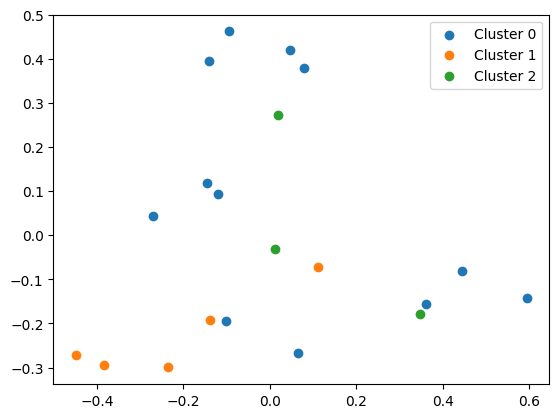

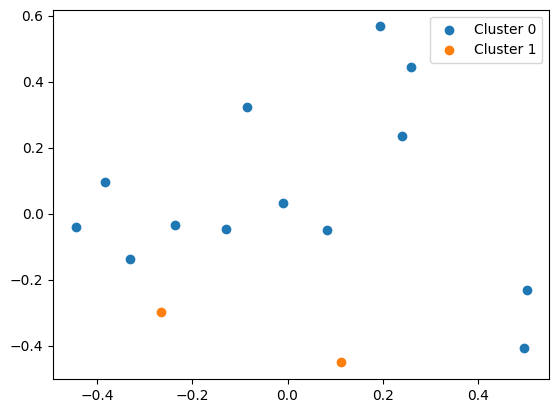

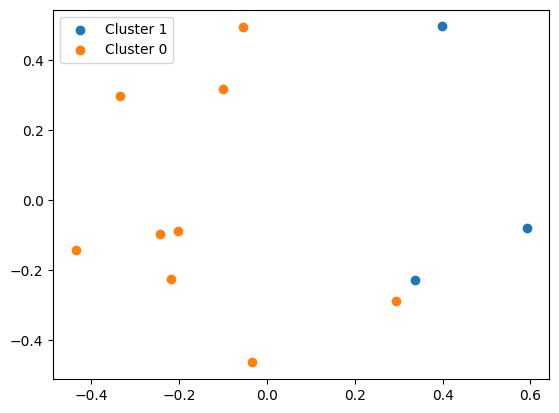

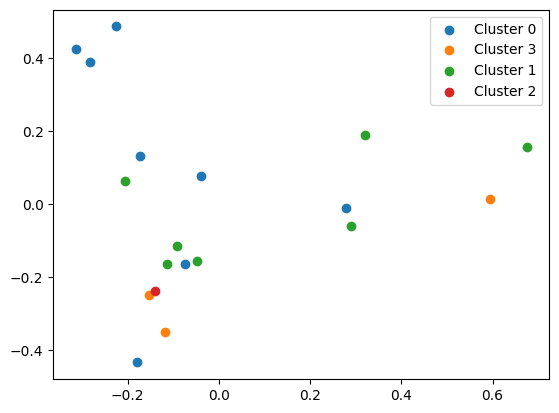

In [165]:
docs = documents[:4]

for doc in docs:
    clusters = sentence_clustering(doc, max_clusters=5)
    plot_clusters(clusters)

The way we are selecting the best clustering solution is by using the silhouette score, which is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Other than that we are using the Calinski-Harabasz index, which is the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters.

The number of cluster is determined usign minimum 2 or maximum the number of sentences in the document. Not sure if this is the best approach, but we will see.

*B) Summarization*

In [294]:
# Summarizatio part
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

def summarization(doc:str, clusters:dict, I=None, **kwargs):

    # Workflow:
    # 1. Choose the the best number of sentences to extract from based on the numebr of clusters
    # 2. Choose the best sentences to extract from each cluster, using the centroid of the cluster
    # 3. Return the summary as a string

    # Problems: How many sentences should we extract from each cluster?
    # Answer: We can use the elbow method to find the optimal number of sentences to extract from each cluster

    # Problems: How do we know if the sentences are good?
    # Answer: We can use the centroid of the cluster to extract the best sentences

    # Best number
    # We can try to do some calculation using the number of clusters.
    # Like: We have a total of n sentences and k clusters,
    # we can try to extract n/k sentences from each cluster.

    number_of_sentences = kwargs.get("number_of_sentences", 1)
    # We keep 1 at the beginning to see how it goes

    # Calculate the centroid of each cluster
    centroids = {}
    vectorizer = TfidfVectorizer(stop_words="english")

    for key, value in clusters.items():
        X = vectorizer.fit_transform(value)
        centroids[key] = np.asarray(X.mean(axis=0)).flatten()
      
        

    print(f"Number of clusters: {len(clusters)}")

    final_summary = ""
        
    sentences = nltk.sent_tokenize(doc)
    X = vectorizer.fit_transform(sentences)
    for k in clusters.keys():
        phrases = clusters[k]

        sentences_vectors = vectorizer.transform([phrase for phrase in phrases])
        centroid = centroids[k].reshape(1, -1)

        distances = []
        for i in range(len(phrases)):
            distances.append(cosine_similarity(sentences_vectors[i].reshape(1, -1), centroid)[0][0])

        # Sort the sentences based on the distance from the centroid
        sentences_indices = np.argsort(distances, axis=0).flatten()
        sentences_indices = sentences_indices[::-1]

        # Extract the best sentences
        for i in range(number_of_sentences):
            final_summary += sentences[sentences_indices[i]] + " "

    return final_summary

In [295]:
# Try with doc 0
doc = documents[0]

clusters = sentence_clustering(doc)
summarization(doc, clusters)

Number of clusters: 10


ValueError: Expected 2D array, got 1D array instead:
array=[0.14131551 0.10097666 0.10097666 0.14131551 0.14131551 0.14131551
 0.10097666 0.10097666 0.10097666 0.10097666 0.10097666 0.14131551
 0.10097666 0.17239288 0.20195332 0.10097666 0.10097666 0.14131551
 0.10097666 0.14131551 0.10097666 0.14131551 0.14131551 0.10097666
 0.17239288 0.14131551 0.10097666 0.10097666 0.10097666 0.10097666
 0.10097666 0.14131551 0.10097666 0.17239288].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

*C) Keyword extraction*

In [10]:
#code, statistics and/or charts here

*D) Evaluation*

In [11]:
#code, statistics and/or charts here

<h3>Part II: classification</h3>

*A) Feature extraction*

In [12]:
#code and statistics here

*B) Classification*

In [13]:
#code here

*C) Ranking extension*

In [14]:
#code here

*D) Evaluation*

In [15]:
#code, statistics and/or charts here

<H2>Question materials (optional)</H2>

<H3>Part I: clustering</H3>

**(1)** Do clustering-guided summarization alters the behavior and efficacy of the IR system?

In [16]:
#code, statistics and/or charts here

**(2)** How sentence representations, clustering choices, and rank criteria impact summarization?

In [17]:
#code, statistics and/or charts here

**...** (additional questions with empirical results)

<H3>END</H3>